In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.spatial.distance import cdist
import pyvista as pv
import nibabel as nib
import pickle



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pickle
import h5py

In [ ]:
total_subjects=['sub1','sub2','sub3','sub4','sub5','sub6','sub7','sub8','sub9','sub10','sub11','sub12','sub13','sub14','sub15']


In [ ]:
strip_grid_no_list={'sub1':[0,1,2,3],
                    'sub2':[0,1,2,3,4,5],
                    'sub3':[0,1,2,3,4],
                    'sub4':[0,1,2,3,4],
                    'sub5':[0,1,2,3],
                    'sub6':[0,1,2,3,4],
                    'sub7':[0,1,2],
                    'sub8':[0,2,3],
                    'sub9':[0,1,2,3],
                    'sub10':[0,1],
                    'sub11':[0,1,2],
                    'sub12':[0,1,2],
                    'sub13':[0,1,2,3],
                    'sub14':[0,1,2,3],
                    'sub15':[0,1,2,3,4]
}
                   

# Among the two lists in badnull_ans_dict, the first contains cases where the answer was stated incorrectly (i.e., the opposite of the correct answer), and the second contains experimental errors—such as failing to give an answer, speaking during the baseline period, or similar issues.
liv_nonliv_badnull_ans_dict = {'sub1': [[], []],
                               'sub2': [[], []],
                               'sub3': [[49], []],
                               'sub4': [[], []],
                               'sub5': [[5, 7], []],
                               'sub6': [[41], [17]],
                               'sub7': [[], []],
                               'sub8': [[], [33]],
                               'sub9' : [[8],[13]],
                               'sub10' : [[],[36]],
                               'sub11' : [[],[]],
                               'sub12' : [[],[]],
                               'sub13' : [[16],[]],
                               'sub14': [[10], [23]],
                               'sub15': [[], []],
                               }


body_nonbody_badnull_ans_dict = {'sub1': [[], []],
                               'sub2': [[], []],
                               'sub3': [[], []],
                               'sub4': [[], [3,7]],
                               'sub5': [[], []],
                               'sub6': [[], []],
                               'sub7': [[], []],
                               'sub8': [[], []],
                               'sub9' : [[],[]],
                               'sub10' : [[],[4]],
                               'sub11' : [[],[]],
                               'sub12' : [[],[]],
                               'sub13' : [[],[]],
                               'sub14': [[], [0]],
                               'sub15': [[], []],
                               }


body_nonbody_badnull_ans_dict = {'sub1': [[], []],
                                 'sub2': [[], []],
                                 'sub3': [[], []],
                                 'sub4': [[], [3+72, 7+72]],
                                 'sub5': [[], []],
                                 'sub6': [[], []],
                                 'sub7': [[], []],
                                 'sub8': [[], []],
                                 'sub9' : [[],[]],
                                 'sub10' : [[i for i in range(54,72)],[4+72]+[i for i in range(126,144)]],
                                 'sub11' : [[],[]],
                                 'sub12' : [[],[]],
                                 'sub13' : [[],[]],
                                 'sub14': [[], [0+72]],
                                 'sub15': [[], []],
                                 }


In [ ]:
# add 72 in bodypart
def bad_trial_giver(pat_name, strip_grid_no_list):
    total_badtrial=[[],[],[],[],[],[],[]]
    ch_info_dirs = 'data_path/'+pat_name+'/'+pat_name+'good_ch.mat'
    with h5py.File(ch_info_dirs, 'r') as file:
        ch_info_raw = file['good_ch_index'][:]
    max_grid_group = int(ch_info_raw[-1]//1000)
    ch_info = [[] for i in range(max_grid_group)]
    for each_ch_info in ch_info_raw:
        grid_group = int(each_ch_info//1000)-1
        grid_num = int(each_ch_info%1000)
        ch_info[grid_group].append(grid_num)
    ch_indexing=[0]
    cnter_ch=0
    strip_grid_no = str(strip_grid_no_list[pat_name])
    file_path = "l_"+pat_name+'_'+strip_grid_no+"_index.pkl"
    with open(file_path, 'rb') as f:
        checkbox_indexs = pickle.load(f)
    print(checkbox_indexs)
    file_path = "badtrials/l_"+pat_name+'_'+strip_grid_no+".pkl"
    with open(file_path, 'rb') as f: #6
        l_badtrial_raw = np.array(pickle.load(f))
    
    file_path = "badtrials/b_"+pat_name+'_'+strip_grid_no+".pkl"
    with open(file_path, 'rb') as f: #7
        b_badtrial_raw = np.array(pickle.load(f))    
    
    for i in ch_info:
        ch_indexing.append(ch_indexing[cnter_ch]+len(i))
        cnter_ch +=1
    
    for idx in range(len(strip_grid_no_list[pat_name])):
        checkbox_index = checkbox_indexs[idx]
        ch_cnt = len(ch_info[strip_grid_no_list[pat_name][idx]])
        for point in range(7):
            check_bullean_l = np.where(np.sum(l_badtrial_raw[checkbox_index,:,:][:,[0,point+1]],axis=1)>0,1,0)
            check_bullean_b = np.where(np.sum(b_badtrial_raw[checkbox_index,:,:][:,[0,point+1]],axis=1)>0,1,0)
            bad_trial_list = []
            for i in range(72):
                if check_bullean_l[i] == 1:
                    bad_trial_list.append(i)
            for i in range(72):
                if check_bullean_b[i] == 1:
                    bad_trial_list.append(i+72)
            for i in range(ch_cnt):
                total_badtrial[point].append(bad_trial_list)
    return total_badtrial
    
    
    

In [9]:
def create_dissimilarity_matrix_trialbased(data):
    """
    Create an n x n dissimilarity score matrix based on absolute differences.

    Parameters:
        data (list or np.ndarray): A 1D array or list of n elements.

    Returns:
        np.ndarray: An n x n dissimilarity score matrix.
    """
    n = len(data)
    data = np.array(data)  # Ensure the input is a numpy array
    
    # Initialize an n x n matrix with zeros
    dissimilarity_matrix = np.zeros((n, n))

    # Fill the matrix with absolute differences
    for i in range(n):
        for k in range(n):
            dissimilarity_matrix[i, k] = abs(data[i] - data[k])

    return dissimilarity_matrix

# Example usage
data = [1, 4, 7, 10]
dissimilarity_matrix = create_dissimilarity_matrix_trialbased(data)
print(dissimilarity_matrix)


[[0. 3. 6. 9.]
 [3. 0. 3. 6.]
 [6. 3. 0. 3.]
 [9. 6. 3. 0.]]


In [10]:
def create_dissimilarity_matrix_trialbased(data):
    """
    Create an n x n dissimilarity score matrix based on absolute differences.

    Parameters:
        data (list or np.ndarray): A 1D array or list of n elements.

    Returns:
        np.ndarray: An n x n dissimilarity score matrix.
    """
    n = len(data)
    # Initialize an n x n matrix with zeros
    dissimilarity_matrix = np.zeros((n, n))
    print(np.max(data), np.min(data))
    # Fill the matrix with absolute differences
    for i in range(n):
        for k in range(n):
            dissimilarity_matrix[i, k] = abs(data[i] - data[k])

    return dissimilarity_matrix

# Example usage
data = [1, 4, 7, 10]
dissimilarity_matrix = create_dissimilarity_matrix_trialbased(data)
print(dissimilarity_matrix)


10 1
[[0. 3. 6. 9.]
 [3. 0. 3. 6.]
 [6. 3. 0. 3.]
 [9. 6. 3. 0.]]


In [11]:
def create_dissimilarity_matrix_trialbased_corr(data):
    """
    Create an n x n dissimilarity score matrix based on absolute differences.

    Parameters:
        data (list or np.ndarray): A 1D array or list of n elements.

    Returns:
        np.ndarray: An n x n dissimilarity score matrix.
    """
    n = len(data)
    data = np.array(data)  # Ensure the input is a numpy array
    
    # Initialize an n x n matrix with zeros
    dissimilarity_matrix = np.zeros((n, n))

    # Fill the matrix with absolute differences
    for i in range(n):
        for k in range(n):
            dissimilarity_matrix[i, k] = 1 - np.corrcoef(data[i,:] - data[k,:])[0,1]

    return dissimilarity_matrix

In [12]:
with open('C:/Users/yirye/Desktop/data_analisys_code_for_Semsess/1016_random_analysis/topomap/left_bestmodel_index.pickle', 'rb') as f:
    left_bestmodel_index = pickle.load(f)

with open('C:/Users/yirye/Desktop/data_analisys_code_for_Semsess/1016_random_analysis/topomap/right_bestmodel_index.pickle', 'rb') as f:
    right_bestmodel_index = pickle.load(f)


In [ ]:
#for type 3
from sklearn.decomposition import PCA
lefthemi_subjects = ['sub1','sub2','sub3','sub4','sub5','sub6','sub10','sub13','sub14','sub15']
type3_leftpSTG_ch_lists = [[27, 32], [0, 1, 2, 6, 7, 30], [], [], [31, 32], [44], [], [], [], []]
root_path="savedir/"
left_vertex_index = []
left_data_list=[]
left_p_list=[]
left_goodtrial_cnt=[]
l_total_acti=[]
l_total_acti_sesscut=[]
for lh_subject in lefthemi_subjects:
    print("==========================")
    print(lh_subject)
    subject_index = lefthemi_subjects.index(lh_subject)
    sub_no_tot = total_subjects.index(lh_subject)
    # 파일 불러오기
    file_path = root_path + lh_subject +"rmaxpoint_HGacti_Q_goodtrialeach.pkl"
    with open(file_path, 'rb') as f:
        acti_goodeach = pickle.load(f)
    
    file_path = root_path + lh_subject +"rmaxpoint_ans_Q_goodtrialeach.pkl"
    with open(file_path, 'rb') as f:
        ans_goodeach = pickle.load(f)

    file_path = root_path + lh_subject +"rmaxpoint_sess_Q_goodtrialeach.pkl"
    with open(file_path, 'rb') as f:
        sess_goodeach = pickle.load(f)
        
    file_path = root_path + lh_subject +"rmax_point.pkl"
    with open(file_path, 'rb') as f:
        rmax_point = pickle.load(f)
    if lh_subject != "sub3" :
      for ch in range(len(acti_goodeach)):
        left_goodtrial_cnt.append(len(ans_goodeach[ch]))
        if ch in left_bestmodel_index[0]:
            model_type = 0
        if ch in left_bestmodel_index[1]:
            model_type = 1
        if ch in left_bestmodel_index[2]:
            model_type = 2
        if ch in left_bestmodel_index[3]:
            model_type = 3
        acti_ch = acti_goodeach[ch][:,model_type]
        ans_index=[[],[],[],[]]
        ans_sess_index=[[] for i in range(16)]
        for trial in range(len(ans_goodeach[ch])):
            ans_index[int(ans_goodeach[ch][trial])].append(trial)
            ans_sess_index[int(ans_goodeach[ch][trial])*4+int(sess_goodeach[ch][trial])].append(trial)
            
        #print(acti_ch.shape)
        l_total_acti.append([np.mean(acti_ch[ans_index[0]]),np.mean(acti_ch[ans_index[1]]),np.mean(acti_ch[ans_index[2]]),np.mean(acti_ch[ans_index[3]])])
        if lh_subject !="sub10":
          acti_sesscut= [np.mean(acti_ch[ans_sess_index[i]]) for i in range(16)]
          l_total_acti_sesscut.append(acti_sesscut)
          print(len(l_total_acti_sesscut))
        if lh_subject =="sub10":
          print(len(l_total_acti_sesscut))
    else: 
      for ch in [40,41]:
        left_goodtrial_cnt.append(len(ans_goodeach[ch]))
        if ch in left_bestmodel_index[0]:
            model_type = 0
        if ch in left_bestmodel_index[1]:
            model_type = 1
        if ch in left_bestmodel_index[2]:
            model_type = 2
        if ch in left_bestmodel_index[3]:
            model_type = 3
        acti_ch = acti_goodeach[ch][:,model_type]
        ans_index=[[],[],[],[]]
        ans_sess_index=[[] for i in range(16)]
        for trial in range(len(ans_goodeach[ch])):
            ans_index[int(ans_goodeach[ch][trial])].append(trial)
            ans_sess_index[int(ans_goodeach[ch][trial])*4+int(sess_goodeach[ch][trial])].append(trial)
        #print(acti_ch.shape)
        l_total_acti.append([np.mean(acti_ch[ans_index[0]]),np.mean(acti_ch[ans_index[1]]),np.mean(acti_ch[ans_index[2]]),np.mean(acti_ch[ans_index[3]])])
        acti_sesscut= [np.mean(acti_ch[ans_sess_index[i]]) for i in range(16)]
        l_total_acti_sesscut.append(acti_sesscut)

In [19]:
l_total_acti_sesscutnp = np.array(l_total_acti_sesscut)
print(l_total_acti_sesscutnp.shape)

(430, 16)


In [20]:
l_total_acti_np = np.array(l_total_acti)
print(l_total_acti_np.shape)

(442, 4)


In [35]:
left_bestmodel_index_sesscut = [[],[],[],[]]
for i in range(4):
    for k in left_bestmodel_index[i]:
        if k<313:
            left_bestmodel_index_sesscut[i].append(k)
        else:
            if k > 324:
                left_bestmodel_index_sesscut[i].append(k-12)
print(len(left_bestmodel_index_sesscut[0]) + len(left_bestmodel_index_sesscut[1])  +len(left_bestmodel_index_sesscut[2])   +len(left_bestmodel_index_sesscut[3]) )  

430


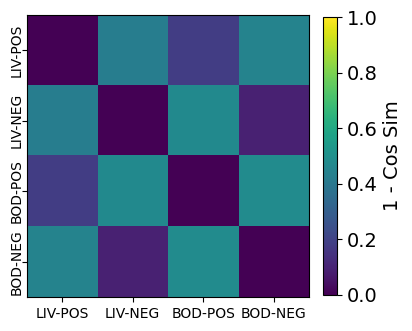

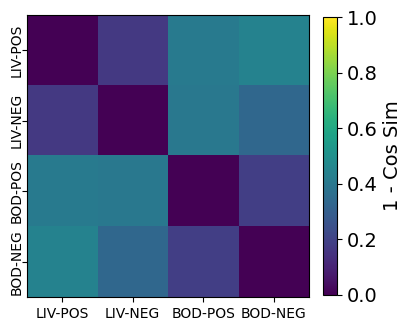

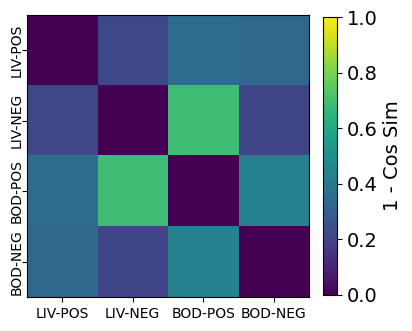

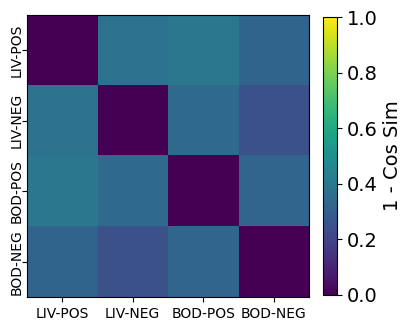

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
labels = ['LIV-POS', 'LIV-NEG', 'BOD-POS', 'BOD-NEG']

for modeltype in range(4):
    idx__=[i for i in range(442) if i not in range(313,325)]
    type_acti = l_total_acti_np[idx__,:][left_bestmodel_index_sesscut[modeltype],:]
    dissim_matrix = np.zeros((4,4))
    for i in range(4):
      for k in range(4):
        if i !=k :
            corr = cosine_similarity(type_acti[:,i].reshape(1, -1),type_acti[:,k].reshape(1, -1))
            dissim_matrix[i,k] = 1- corr
    names=["NEG","CON","NEGxCON", "NEGxCON+inter"]
    title=f"   RDM for {names[modeltype]} encoding chs (left hemi.)"
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    im = ax.imshow(dissim_matrix, vmax=1)
    #ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.04)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("1 - Cos Sim", fontsize=14) # shrink 길이 조절
    plt.yticks(ticks=np.arange(4), labels=labels, rotation=90,ha='center', va='center')
    ax.set_xticks(np.arange(4)); ax.set_xticklabels(labels)
    #ax.set_yticks(np.arange(4)); ax.set_yticklabels(labels); ax.set_ytickrotation(90)
    plotsavepath = "plots_multich_RSA/"+"left_totalmean_"+title+".png" 
    plt.savefig(plotsavepath,dpi=300)
    plt.show()

In [ ]:
dissim_matrix

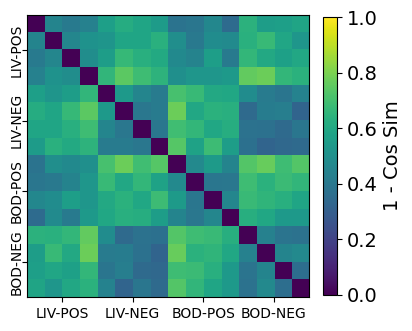

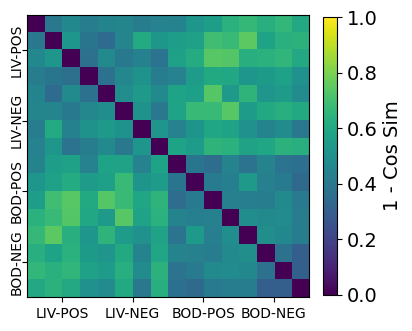

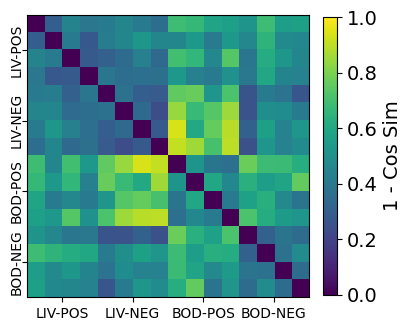

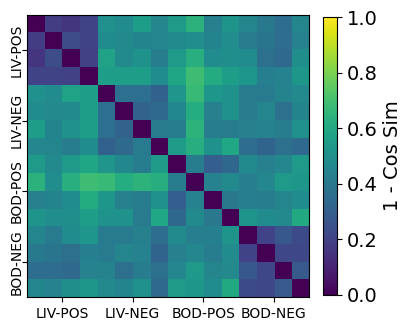

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
labels = ['LIV-POS', 'LIV-NEG', 'BOD-POS', 'BOD-NEG']

#sub10 dont have session4, so pop out 313-325 
for modeltype in range(4):
    type_acti = l_total_acti_sesscutnp[left_bestmodel_index_sesscut[modeltype],:]
    dissim_matrix = np.zeros((16,16))
    for i in range(16):
      for k in range(16):
        if i !=k :
            corr = cosine_similarity(type_acti[:,i].reshape(1, -1),type_acti[:,k].reshape(1, -1))
            dissim_matrix[i,k] = 1- corr
    names=["NEG","CON","NEGxCON", "NEGxCON+interaction"]
    title=f"   RDM for {names[modeltype]} encoding chs (left hemi.)"
    '''
    plt.imshow(dissim_matrix, vmax=1)
    plt.title(title)
    plt.colorbar(label="1 - Cos Sim")
    plt.xticks(ticks=np.arange(2,16,4)-0.5, labels=labels)
    plt.yticks(ticks=np.arange(2,16,4)-0.5, labels=labels, rotation=90,ha='center', va='center')
    '''
    names=["NEG","CON","NEGxCON", "NEGxCON+inter"]
    title=f"   RDM for {names[modeltype]} encoding chs (left hemi.)"
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    im = ax.imshow(dissim_matrix, vmax=1)
    #ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.04)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("1 - Cos Sim", fontsize=14) # shrink 길이 조절
    plt.yticks(ticks=np.arange(2,16,4)-0.5, labels=labels, rotation=90,ha='center', va='center')
    ax.set_xticks(ticks=np.arange(2,16,4)-0.5); ax.set_xticklabels(labels)
    #ax.set_yticks(np.arange(4)); ax.set_yticklabels(labels); ax.set_ytickrotation(90)
    
    plotsavepath = "plots_multich_RSA/"+"left_sessionbased_"+title+".png" 
    plt.savefig(plotsavepath,dpi=300)
    plt.show()